# GP rotation periods

In [1]:
import corner
import emcee3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.stats import LombScargle

import george
from george.kernels import ExpSquaredKernel, ExpSine2Kernel
import kplr
import kepler_data as kd

%matplotlib inline

Download a light curve

In [2]:
kepid = "1026146".zfill(9)
247520207
client = kplr.API()
star = client.star(kepid)
star.get_light_curves(fetch=True, short_cadence=False)

[<LightCurve("KPLR001026146-2009166043257_LC")>,
 <LightCurve("KPLR001026146-2009259160929_LC")>,
 <LightCurve("KPLR001026146-2009350155506_LC")>,
 <LightCurve("KPLR001026146-2010078095331_LC")>,
 <LightCurve("KPLR001026146-2010174085026_LC")>,
 <LightCurve("KPLR001026146-2010265121752_LC")>,
 <LightCurve("KPLR001026146-2010355172524_LC")>,
 <LightCurve("KPLR001026146-2011073133259_LC")>,
 <LightCurve("KPLR001026146-2011177032512_LC")>,
 <LightCurve("KPLR001026146-2011271113734_LC")>,
 <LightCurve("KPLR001026146-2012004120508_LC")>,
 <LightCurve("KPLR001026146-2012088054726_LC")>,
 <LightCurve("KPLR001026146-2012179063303_LC")>,
 <LightCurve("KPLR001026146-2012277125453_LC")>,
 <LightCurve("KPLR001026146-2013011073258_LC")>,
 <LightCurve("KPLR001026146-2013098041711_LC")>,
 <LightCurve("KPLR001026146-2013131215648_LC")>]

In [3]:
LC_DIR = "/Users/ruthangus/.kplr/data/lightcurves/{}".format(kepid)
x, y, yerr = kd.load_kepler_data(LC_DIR)
x -= x[0]

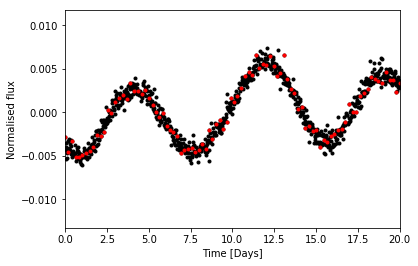

In [4]:
plt.plot(x, y, "k.")
plt.xlabel("Time [Days]")
plt.ylabel("Normalised flux")
plt.xlim(0, 20)

# Thin data
x, y, yerr = x[:1000:10], y[:1000:10], yerr[:1000:10]
plt.plot(x, y, "r.")

(0, 20)

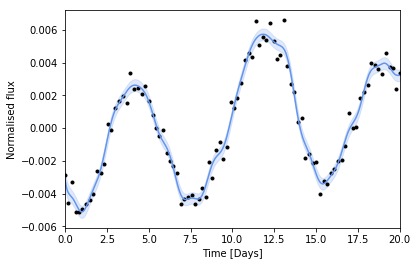

In [6]:
a, l, g, p = .1, 1, 1, 8
k = a * ExpSquaredKernel(l) * ExpSine2Kernel(g, p)
gp = george.GP(k)
gp.compute(x, yerr)

x_pred = np.linspace(min(x), max(x), 500)
mu, var = gp.predict(y, x_pred, return_var=True)

plt.plot(x, y, "k.")
plt.plot(x_pred, mu, color="CornFlowerBlue")
plt.fill_between(x_pred, mu - np.sqrt(var), mu + np.sqrt(var), color="CornFlowerBlue", alpha=0.2)
plt.xlabel("Time [Days]")
plt.ylabel("Normalised flux")
plt.xlim(0, 20)

Now optimise the GP parameters

In [8]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("A = ", result.x[0])
print("l = ", result.x[1])
print("gamma = ", result.x[2])
print("period = ", result.x[3])

      fun: -558.7759835149601
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([  6.59766641e-09,   1.75007493e-08,   6.03171561e-10,
        -2.41203061e-09])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-10.977133  ,   1.48798747,   0.9995853 ,   8.00082929])
A =  -10.9771329957
l =  1.4879874704
gamma =  0.999585301737
period =  8.00082928717


(0, 20)

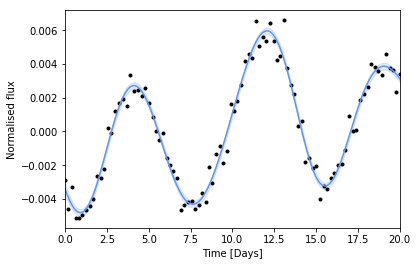

In [10]:
gp.compute(x, yerr)
mu, var = gp.predict(y, x_pred, return_var=True)

plt.plot(x, y, "k.")
plt.plot(x_pred, mu, color="CornFlowerBlue")
plt.fill_between(x_pred, mu - np.sqrt(var), mu + np.sqrt(var), color="CornFlowerBlue", alpha=0.2)
plt.xlabel("Time [Days]")
plt.ylabel("Normalised flux")
plt.xlim(0, 20)

Try MCMC?

To use GProtation, type something like:

>> gprot-fit KOI_or_KIC_number --kepler -v

In the command line.